# モニタリングを実施する

複数の実験の再現性をモニタリングします。  
モニタリングでは、[pipeline.json](../../../experiments.pipeline.json)に設定された順番に実験が再現されます。  
以下のセルを上から実行してください。  
2回目以降の実行では、画面上部に表示される以下のボタンをクリックしてから実行して下さい。
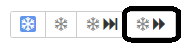

## 1.パイプライン定義ファイルのチェック結果を確認する

パイプライン定義ファイルとパッケージ群の情報に相違がないか確認します。  
以下のセルを実行し、エラーが起きないことを確認してください。  
エラーが起きた場合は、表示されたリンクに遷移してパイプライン定義ファイルを修正＆エラーが起きなくなるまで再実行を繰り返してください。

In [ ]:
import os
import json
import glob

# 作業ディレクトリに移動
%cd ~/experiments/

# 実験パイプライン定義ファイルの読み込み
pipeline = json.load(open("pipeline.json"))
print("実験パイプライン：" + str(pipeline))

# 実験パッケージ群の読み込み
files = glob.glob("./*/")

experiments = []
for file in files:
    experiments += [os.path.basename(file[:-1])]
print("実験パッケージ　：" + str(experiments))

# 元のディレクトリに移動
%cd -

# 過不足の確認
if set(pipeline) != set(experiments):
    link = "https://jupyter.cs.rcos.nii.ac.jp" + os.environ["JUPYTERHUB_SERVICE_PREFIX"] + "edit/experiments/pipeline.json"
    raise Exception("実験パイプラインと実験パッケージ間で相違があります\n\n以下のURLに遷移して修正してください\n" + link)

## 2.実験パイプラインを実行する

### - 2.1 実験パイプラインの定義情報を取得する

In [ ]:
import json

# 作業ディレクトリに移動
%cd ~/experiments/

# 実験パイプライン定義ファイルの読み込み
pipeline = json.load(open("pipeline.json"))
print("実験パイプライン：" + str(pipeline))

### - 2.2 実験パッケージを最新化する

In [ ]:
for experiment in pipeline:
    %cd $experiment
    !git pull
    %cd ../

### - 2.3 実験パイプラインを実行する

In [ ]:
%cd ~/experiments/

import papermill

outputs = []

for experiment in pipeline:
    print("\n============================================================ " + experiment)

    print("\n# 出力ディレクトリの初期化")
    cmd = "rm -rf " + experiment + "/output_data/*"
    print("$ " + cmd)
    !$cmd
    
    print("\n前実験の出力データを当実験の入力データとして複製")
    for output in outputs:
        cmd = "cp -rf " + output + "/output_data/* " + experiment + "/input_data/" 
        print("$ " + cmd)
        !$cmd

    print("\n実験再現のための環境構築")
    cmd = "pip install -r " + experiment + "/requirements.txt"
    print("$ " + cmd)
    !$cmd

    print("\n実験ソースコードの実行")
    cmd = experiment + "/source/"
    print("$ cd " + cmd)
    %cd $cmd

    papermill.execute_notebook("main.ipynb", "log.ipynb")
    
    cmd = "-"
    print("$ cd " + cmd)
    %cd $cmd

    print("\n次実験に備えて本実験の出力データを登録")
    outputs += [experiment]

### - 2.4 このノートブックを保存する

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

### - 2.5 実行結果をデータガバナンス機能に反映する

In [ ]:
# %cd ~/
# !git add ~/
# !git commit -m 'モニタリング実施'

In [ ]:
import papermill as pm

pm.execute_notebook(
    '../util/datalad_save_push.ipynb',
    '-',
    parameters = dict(SAVE_MESSAGE = 'パイプライン構築', PATH = [未定])
)

## 3.[FLOW](../FLOW.md)に戻る
